## data prepocessing

In [1]:
import os
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib

project_root = '/content/drive/MyDrive/story_generation_comprehension'
dataset_path = os.path.join(project_root, 'story_generator', 'dataset', 'game_data_with_improvement.csv')


In [5]:
# --- Load Data ---
print(f" Loading dataset from: {dataset_path}")

if os.path.exists(dataset_path):
    df = pd.read_csv(dataset_path)

    # Quick validation
    print(" Dataset Loaded Successfully!")
    print(f"Shape: {df.shape} (Rows, Columns)")

    # Display first few rows to verify content
    display(df.head())
else:
    print(" Error: File not found.")
    print(f"Expected location: {dataset_path}")
    print("Please verify that you ran the 'Data Generation' notebook first.")

 Loading dataset from: /content/drive/MyDrive/story_generation_comprehension/story_generator/dataset/game_data_with_improvement.csv
 Dataset Loaded Successfully!
Shape: (100000, 8) (Rows, Columns)


,timestamp,success_count_mark,attempt_count,attempt_count_mark,score_total_level,game_level,engagement_time_Total_sec,improvement_score
0,2025-11-01 12:54:00,507,7,700,85,7,4237.155620,6.362051
1,2025-11-01 15:13:00,86,4,400,60,14,1351.520273,7.537844
2,2025-11-01 14:29:00,58,9,900,53,12,3780.517856,4.221079
3,2025-11-01 15:43:00,325,4,400,90,6,1122.618317,6.630192
4,2025-11-01 11:48:00,181,9,900,60,1,4000.145032,1.659189


In [6]:
# Remove the timestamp column as it's not necessary for the model
df = df.drop(columns=["timestamp"])

# Separate X and y
X = df.drop(columns=["improvement_score","attempt_count"])
y = df["improvement_score"]

# Initialize StandardScaler for X and y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform X and y using the scalers
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Save the scalers separately
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

print("Data preprocessing complete.")

Data preprocessing complete.


## model training

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
import matplotlib.pyplot as plt
import joblib
from sklearn.linear_model import LinearRegression

In [8]:
# Load the scalers
scaler_X = joblib.load("scaler_X.pkl")
scaler_y = joblib.load("scaler_y.pkl")

In [9]:
# Separate X and y
X = df.drop(columns=["improvement_score","attempt_count"])
y = df["improvement_score"].ravel()

print(y)


# Scale the dataset
X_scaled = scaler_X.transform(X)
y_scaled = scaler_y.transform(y.reshape(-1, 1))
print(y_scaled)

[6.36205114 7.53784441 4.22107914 ... 3.44560097 5.7011388  4.48860472]
[[ 0.6557105 ]
 [ 1.30061998]
 [-0.51858875]
 ...
 [-0.94392988]
 [ 0.29320745]
 [-0.37185396]]


/tmp/ipython-input-2516469692.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = df["improvement_score"].ravel()


In [10]:
# Split the dataset into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

### RF

In [11]:
# Create and train a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train.ravel())

RandomForestRegressor(random_state=42)

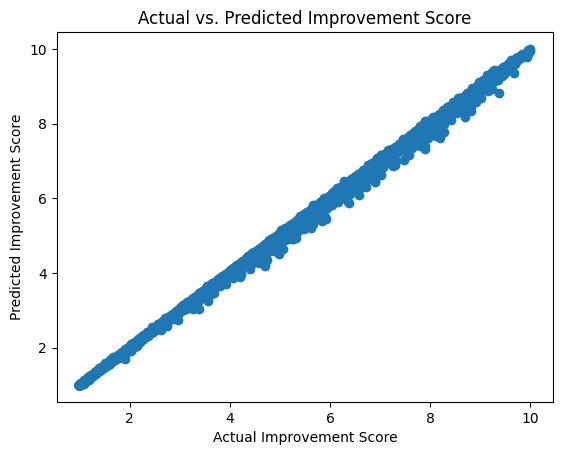

In [12]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Inverse transform to get back the original scale
y_pred_original_scale = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original_scale = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Plot the predicted vs. actual improvement scores
plt.scatter(y_test_original_scale, y_pred_original_scale)
plt.xlabel("Actual Improvement Score")
plt.ylabel("Predicted Improvement Score")
plt.title("Actual vs. Predicted Improvement Score")
plt.show()

In [13]:
import joblib

# Save the trained model to a file
joblib.dump(rf_model, "rf_model.pkl")

print("Model saved as 'rf_model.pkl'.")

Model saved as 'rf_model.pkl'.


### LR

In [14]:
# Step 4: Train the Model
model_LR = LinearRegression()
model_LR.fit(X_train, y_train.ravel())

LinearRegression()

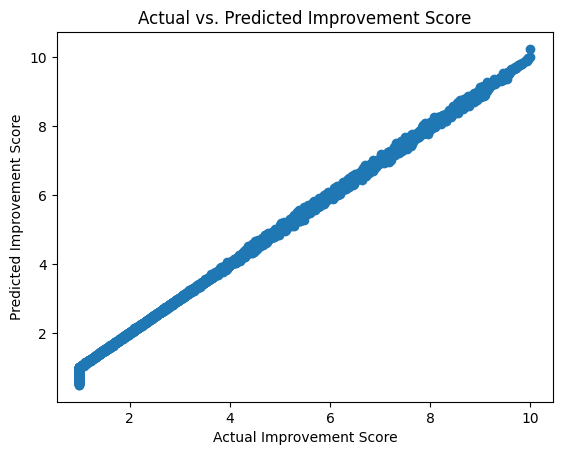

In [15]:
# Make predictions on the test set
y_pred = model_LR.predict(X_test)

# Inverse transform to get back the original scale
y_pred_original_scale = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original_scale = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Plot the predicted vs. actual improvement scores
plt.scatter(y_test_original_scale, y_pred_original_scale)
plt.xlabel("Actual Improvement Score")
plt.ylabel("Predicted Improvement Score")
plt.title("Actual vs. Predicted Improvement Score")
plt.show()

In [16]:
import joblib

# Save the trained model to a file
joblib.dump(model_LR, "LR_model.pkl")

print("Model saved as 'LR_model.pkl'.")

Model saved as 'LR_model.pkl'.


### Calculate Evaluation Metrics

### RF model

In [17]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
r2 = r2_score(y_test_original_scale, y_pred_original_scale)

# Training accuracy
y_train_pred = rf_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

# Testing accuracy
test_r2 = r2_score(y_test, y_pred)

print(f"Training R2 Score: {train_r2:.2f}")
print(f"Testing R2 Score: {test_r2:.2f}")


# Calculate additional evaluation metrics
mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
rmse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
explained_variance = explained_variance_score(y_test_original_scale, y_pred_original_scale)

# Print evaluation metrics
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Explained Variance Score: {explained_variance:.2f}")

Training R2 Score: 1.00
Testing R2 Score: 1.00
Mean Squared Error: 0.00
Mean Absolute Error (MAE): 0.01
Root Mean Squared Error (RMSE): 0.00
Explained Variance Score: 1.00


### LR model

In [18]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
r2 = r2_score(y_test_original_scale, y_pred_original_scale)

# Training accuracy
y_train_pred = model_LR.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

# Testing accuracy
test_r2 = r2_score(y_test, y_pred)

print(f"Training R2 Score: {train_r2:.2f}")
print(f"Testing R2 Score: {test_r2:.2f}")


# Calculate additional evaluation metrics
mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
rmse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
explained_variance = explained_variance_score(y_test_original_scale, y_pred_original_scale)

# Print evaluation metrics
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Explained Variance Score: {explained_variance:.2f}")

Training R2 Score: 1.00
Testing R2 Score: 1.00
Mean Squared Error: 0.00
Mean Absolute Error (MAE): 0.01
Root Mean Squared Error (RMSE): 0.00
Explained Variance Score: 1.00


## Inference

In [21]:
%%writefile /content/drive/MyDrive/story_generation_comprehension/app/src/predict_improvement_score.py
import joblib
import pandas as pd
import numpy as np
import os

def predict_improvement_score(success_count_mark, attempt_count_mark, score_total_level, game_level, engagement_time_Total_sec):
    # 1. Load the models and scalers from the 'app/models' folder
    # We use relative paths assuming you are running from the project root

    # Define the path to the models folder
    base_path = "app/models/"

    try:
        scaler_X = joblib.load(os.path.join(base_path, "scaler_X.pkl"))
        scaler_y = joblib.load(os.path.join(base_path, "scaler_y.pkl"))
        LR_model = joblib.load(os.path.join(base_path, "LR_model.pkl"))
    except FileNotFoundError:
        # Fallback: Try looking in the current folder (if running locally without folders)
        scaler_X = joblib.load("scaler_X.pkl")
        scaler_y = joblib.load("scaler_y.pkl")
        LR_model = joblib.load("LR_model.pkl")

    # 2. Prepare the input data
    user_inputs = pd.DataFrame({
        'success_count_mark': [success_count_mark],
        'attempt_count_mark': [attempt_count_mark],
        'score_total_level': [score_total_level],
        'game_level': [game_level],
        'engagement_time_Total_sec': [engagement_time_Total_sec]
    })

    # 3. Scale the input
    user_inputs_scaled = scaler_X.transform(user_inputs)

    # 4. Predict
    predicted_score_scaled = LR_model.predict(user_inputs_scaled)

    # 5. Inverse scale to get the real score
    predicted_score = scaler_y.inverse_transform(predicted_score_scaled.reshape(-1, 1))

    # 6. return the result (flattened to a single number)
    return predicted_score[0][0]

Overwriting /content/drive/MyDrive/story_generation_comprehension/app/src/predict_improvement_score.py


In [24]:
# Import the function from the file we just created
from predict_improvement_score import predict_improvement_score

# Now run your test code
success_count_mark = 500
attempt_count_mark = 900
score_total_level = 55
game_level = 1
engagement_time_Total_sec = 1800

predicted_improvement_score = predict_improvement_score(success_count_mark, attempt_count_mark, score_total_level, game_level, engagement_time_Total_sec)

print(f"Predicted Improvement Score: {predicted_improvement_score:.2f}%")

Predicted Improvement Score: 3.76%
